In [1]:
import sys
import os
script_dir = os.path.abspath(os.path.join('..', '..', 'numpy', '1D'))
sys.path.append(script_dir)

In [2]:
from utils import *
from env import *
from model import *
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import glob

In [3]:
# set directory to folder with model trained with different place field parameter combinations
data_dir = "/Users/mganeshkumar/Library/CloudStorage/OneDrive-HarvardUniversity/Code/online_pf_learning/rebuttal/"

In [18]:
def plot_npc_mfa_dx(pc_init, lr):

    seeds = 50
    rszs = [0.05]
    rmaxs = [5]
    npcs = [4,8,16,32,64,128,256,512] 

    xs = np.linspace(-1,1,1001)
    dxs = np.zeros([len(rmaxs), len(rszs),len(npcs),seeds,len(xs)])
    mfa = np.zeros([len(rmaxs), len(rszs),len(npcs),seeds,len(xs)])
    deltas = np.zeros([len(rmaxs), len(rszs), len(npcs), seeds, 3, 2])

    dxs = np.zeros([len(npcs),seeds,len(xs)])
    mfa = np.zeros([len(npcs),seeds,len(xs)])
    deltas = np.zeros([len(npcs), seeds, 3, 2])

    deltap = np.zeros([len(npcs), seeds])

    thresholds = [1e-3, 1e-2,1e-1]
    rx = reward_func(xs, 0.5, 0.05)


    for r,rmax in enumerate(rmaxs):
        for s, rsz in enumerate(rszs):

            for n,npc in enumerate(npcs):

                if pc_init == 'uni':
                    if lr == 'Same':
                        expt = f"/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.0005plr_0.0005clr_0.0005llr_0.0005alr_0.0005slr_uni_0.5a_0.1s_2a_*s_50000e_5rmax_0.05rsz.pickle"
                    else:

                        expt = f"/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_2a_*s_50000e_5rmax_0.05rsz.pickle"
                else:
                    if lr == 'Same':
                        expt = f"/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.0005plr_0.0005clr_0.0005llr_0.0005alr_0.0005slr_rand_all_1.0a_0.1s_2a_*s_50000e_5rmax_0.05rsz.pickle"
                    else:
                        expt = f"/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_rand_all_1.0a_0.1s_2a_*s_50000e_5rmax_0.05rsz.pickle"

                files = glob.glob(data_dir+expt)
                print(len(files), npc)


                for f,file in enumerate(files):
                    [rewards, params] = saveload(file[:-7], 1, 'load')

                    pcacts = predict_batch_placecell(params, xs)

                    # density
                    com = xs[np.argmax(pcacts,axis=0)]
                    kde = gaussian_kde(com,bw_method=1/10)
                    dxs[n,f] = kde(xs)

                    #mean firing rate
                    mfa[n,f] = np.mean(pcacts,axis=1)


                    # delta

                    for e,threshold in enumerate(thresholds):
                        xr_indices = rx>=threshold
                        x_indices = rx<threshold
                        dxr = dxs[n,f][xr_indices]
                        dxp = dxs[n,f][x_indices]
                        deltas[n,f, e,0] = (np.mean(dxr)-np.mean(dxp))

                        dxr = mfa[n,f][xr_indices]
                        dxp = mfa[n,f][x_indices]
                        deltas[n,f, e,1] = (np.mean(dxr)-np.mean(dxp))



                    # delta weights vs N
                    asterisk_values =int(os.path.basename(file).split('_')[-4][:-1])
                    if pc_init=='uni':
                        initparams = uniform_pc_weights(npc, 2, asterisk_values, sigma=0.1, alpha=0.5, envsize=1)
                    elif pc_init == 'rand_all':
                        initparams = random_all_pc_weights(npc, 2, asterisk_values, sigma=0.1, alpha=1, envsize=1)


                    initcenter = np.linspace(-1,1,npc)
                    initwidth = 0.1
                    initamp = 0.5

                    deltap[n,f] = np.linalg.norm(params[0] - initparams[0]) + np.linalg.norm(params[1] - initparams[1]) + np.linalg.norm(params[2] - initparams[2])
                    deltap[n,f]/= np.linalg.norm(initparams[0]) + np.linalg.norm(initparams[1]) + np.linalg.norm(initparams[2]) 


    if pc_init == 'uni':
        name = f'Homogeneous, {lr} LR'
    else:
        name = f'Heterogeneous, {lr} LR'

    f,axs = plt.subplots(2,4,figsize=(3*4,2*2.5))
    # f.suptitle(f'{lr} learning rates, {name} place field initialization')
    f.suptitle(name)
    axs = axs.flatten()

    for n,npc in enumerate(npcs):

        ax = axs[n]

        dx = np.mean(mfa[n],axis=0)
        dx_ci = 1.96*np.std(mfa[n],axis=0)/np.sqrt(seeds)

        ax.plot(xs, dx, color='r',zorder=1)
        ax.fill_between(xs, dx-dx_ci, dx+dx_ci, alpha=0.2, color='r',zorder=1)
        t1 = xs[np.argmax(dx)]
        ax.axvline(t1, color='r', linestyle='--',label=np.round(t1,3), linewidth=2,zorder=1)

        ax2 = ax.twinx()

        dx3 = np.mean(dxs[n],axis=0)
        ax2.plot(xs, dx3, color='b',zorder=3)

        dx3_ci = 1.96*np.std(dxs[n],axis=0)/np.sqrt(seeds)
        ax2.fill_between(xs, dx3-dx3_ci, dx3+dx3_ci, alpha=0.2, color='b',zorder=3)
        t3 = xs[np.argmax(dx3)]
        ax2.axvline(t3, color='b', linestyle='--',label=np.round(t3,3), linewidth=2,zorder=3)

    
        # Combine legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
        ax.set_ylim([0, np.max(dx3+dx3_ci)*1.1])

        # ax.set_xlabel('$x$')
        if n == 0 or n == 4:
            ax.set_ylabel('$\sum \phi(x)$',color='r')

        if n == 3 or n == 7:
            ax2.set_ylabel('gKDE(COM)',color='b')


        # ax.fill_betweenx(np.linspace(0,maxval), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Target')
        ax.fill_between(xs, reward_func(xs, 0.5, 0.05, amp=1), color='red', alpha=0.25, label='Target',zorder=2)
        ax.axvline(-0.75,ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2,zorder=2)
        ax.hlines(xmin=-1,xmax=1, y=0, colors='k',zorder=2)
        ax.set_title(f'$N={npc}$')
        ax.set_xticks([])
        ax.set_ylim([0, np.max(dx+dx_ci)*1.1])

    f.tight_layout()
    # f.savefig(f'./svgs/1D_dx_mfa_all_{lr}lr_{pc_init}pc.svg')

    f,ax = plt.subplots(figsize=(3,2))
    x = npcs
    y = np.mean(deltap,axis=1)
    ax.errorbar(x=x, y=y, yerr=1.96*np.std(deltap,axis=1)/np.sqrt(seeds))
    ax.set_ylabel('$||\\theta_{final} - \\theta_0||/||\\theta_0||$')
    ax.set_xlabel('$N$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(name)

    f.tight_layout()
    # f.savefig(f'svgs/theta_N_{lr}_{pc_init}.svg')




50 4
50 8
50 16
50 32
50 64
50 128
50 256
50 512
50 4
50 8
50 16
50 32
50 64
50 128
50 256
50 512
50 4
50 8
50 16
50 32
50 64
50 128
50 256
50 512


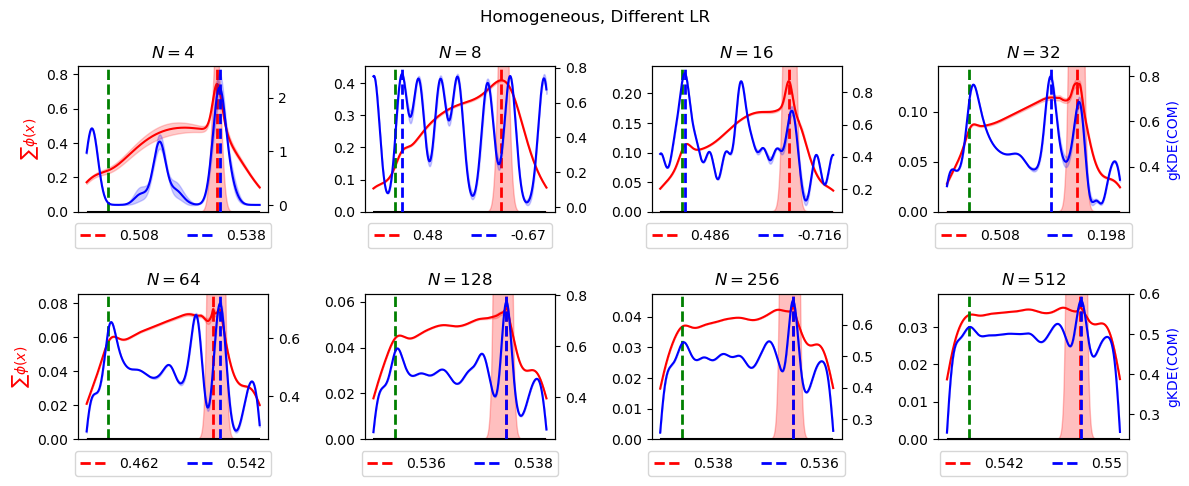

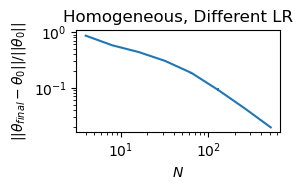

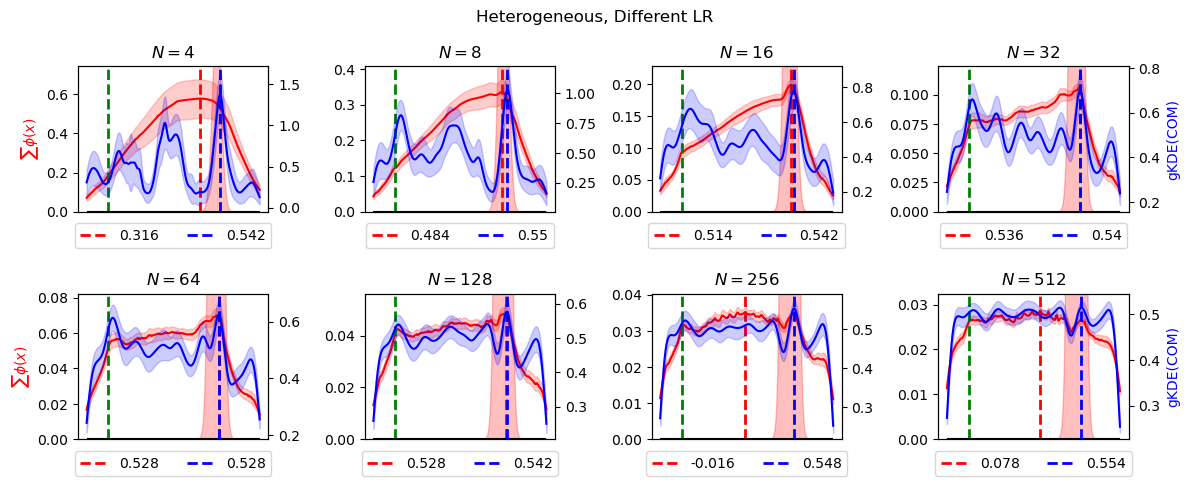

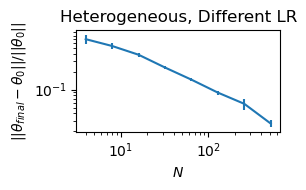

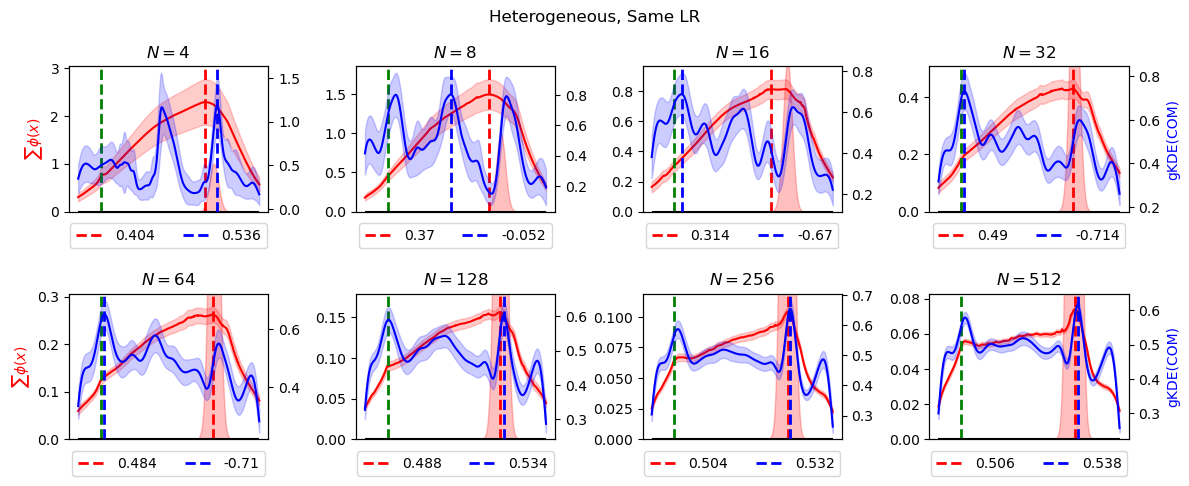

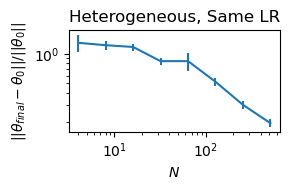

In [19]:
plot_npc_mfa_dx('uni', 'Different')
plot_npc_mfa_dx('rand_all', 'Different')
plot_npc_mfa_dx('rand_all', 'Same')

In [10]:
# Function to fit the model
# Define the functions to fit
def linear(x, a, b):
    return a * x + b

def exponential(x, a, b):
    return a * np.exp(-b * x)

def exponential_(x, a, b, c):
    return a * np.exp(-b * x) + c

def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

def power_law_(x, a, b, c):
    return a * np.power(x, -b) + c

def power_law(x, a, b):
    return a * np.power(x, -b)

def fit_model(x, y, func_type='linear', initial_guess=None):
    if func_type == 'linear':
        func = linear
        if initial_guess is None: initial_guess = [0, 0]
    elif func_type == 'exp':
        func = exponential
        if initial_guess is None: initial_guess = [3, 0]
    elif func_type == 'sigmoid':
        func = sigmoid
        if initial_guess is None: initial_guess = [1, 1, 1]
    elif func_type == 'power':
        func = power_law
        if initial_guess is None: initial_guess = [1, 0]
    else:
        raise ValueError("Unsupported function type. Choose from 'linear', 'exp', 'sigmoid', or 'power'.")
    
    popt, _ = curve_fit(func, x, y, p0=initial_guess, maxfev=10000)
    return popt, func


In [11]:

## difflr, rand_all \  difflr, uni 
lr = 'Different'
pc_init = 'rand_all'
seeds = 50
rszs = [0.025, 0.05,0.1]
rmaxs = [1, 5, 9]
sigmas = [0.1]
npcs = [4, 8,16,32,64,128,256,512, 1024] 
thresholds = [1e-3, 1e-2,1e-1,0.25, 0.5]

xs = np.linspace(-1,1,1001)
dxs = np.zeros([len(rmaxs), len(rszs),len(npcs),seeds,len(xs)])
mfa = np.zeros([len(rmaxs), len(rszs),len(npcs),seeds,len(xs)])
deltas_dx = np.zeros([len(rmaxs), len(rszs), len(npcs), seeds, len(thresholds)])
deltas_mfa = np.zeros([len(rmaxs), len(rszs), len(npcs), seeds, len(thresholds)])

deltap = np.zeros([len(npcs), seeds])

# for r,rmax in enumerate(rmaxs):
for r,rmax in enumerate(rmaxs):
    for s, rsz in enumerate(rszs):

        for n,npc in enumerate(npcs):

            if pc_init == 'uni':
                if lr == 'Same':
                    expt = f"/Users/mganeshkumar/Downloads/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.0005plr_0.0005clr_0.0005llr_0.0005alr_0.0005slr_uni_0.5a_{sigma}s_2a_*s_50000e_{rmax}rmax_{rsz}rsz.pickle"
                else:

                    expt = f"/Users/mganeshkumar/Downloads/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_{sigma}s_2a_*s_50000e_{rmax}rmax_{rsz}rsz.pickle"
            else:
                if lr == 'Same':
                    expt = f"/Users/mganeshkumar/Downloads/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.0005plr_0.0005clr_0.0005llr_0.0005alr_0.0005slr_rand_all_1.0a_0.1s_2a_*s_50000e_{rmax}rmax_{rsz}rsz.pickle"
                else:
                    expt = f"/Users/mganeshkumar/Downloads/dx_data/dx_1D_td_both_0.0bs_0.0ba_0.0sc_0.0ac_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_rand_all_1.0a_0.1s_2a_*s_50000e_{rmax}rmax_{rsz}rsz.pickle"

            files = glob.glob(expt)
            if len(files)<seeds:
                print('!!!', rmax, rsz, len(files), npc)
            else:
                print(rmax, rsz, len(files), npc)


            for f,file in enumerate(files[:seeds]):
                [rewards, params] = saveload(file[:-7], 1, 'load')

                pcacts = predict_batch_placecell(params, xs)

                # density
                com = xs[np.argmax(pcacts,axis=0)]
                kde = gaussian_kde(com,bw_method=1/10)
                dxs[r,s,n,f] = kde(xs)

                #mean firing rate
                mfa[r,s,n,f] = np.mean(pcacts,axis=1)


                # delta
                rx = reward_func(xs, 0.5, rsz)
                for e,threshold in enumerate(thresholds):
                    xr_indices = rx>=threshold
                    x_indices = rx<threshold
                    dxr = dxs[r,s,n,f][xr_indices]
                    dxp = dxs[r,s,n,f][x_indices]
                    deltas_dx[r,s,n,f, e] = (np.mean(dxr)-np.mean(dxp))

                    dxr = mfa[r,s,n,f][xr_indices]
                    dxp = mfa[r,s,n,f][x_indices]
                    deltas_mfa[r,s,n,f, e] = (np.mean(dxr)-np.mean(dxp))



1 0.025 50 4
1 0.025 50 8
1 0.025 50 16
1 0.025 50 32
1 0.025 50 64
1 0.025 50 128
1 0.025 50 256
1 0.025 50 512
1 0.025 50 1024
1 0.05 50 4
1 0.05 50 8
1 0.05 50 16
1 0.05 50 32
1 0.05 50 64
1 0.05 50 128
1 0.05 50 256
1 0.05 50 512
1 0.05 50 1024
1 0.1 50 4
1 0.1 50 8
1 0.1 50 16
1 0.1 50 32
1 0.1 50 64
1 0.1 50 128
1 0.1 50 256
1 0.1 50 512
1 0.1 50 1024
5 0.025 50 4
5 0.025 50 8
5 0.025 50 16
5 0.025 50 32
5 0.025 50 64
5 0.025 50 128
5 0.025 50 256
5 0.025 50 512
5 0.025 50 1024
5 0.05 50 4
5 0.05 50 8
5 0.05 50 16
5 0.05 50 32
5 0.05 50 64
5 0.05 50 128
5 0.05 50 256
5 0.05 50 512
5 0.05 50 1024
5 0.1 50 4
5 0.1 50 8
5 0.1 50 16
5 0.1 50 32
5 0.1 50 64
5 0.1 50 128
5 0.1 50 256
5 0.1 50 512
5 0.1 50 1024
9 0.025 50 4
9 0.025 50 8
9 0.025 50 16
9 0.025 50 32
9 0.025 50 64
9 0.025 50 128
9 0.025 50 256
9 0.025 50 512
9 0.025 50 1024
9 0.05 50 4
9 0.05 50 8
9 0.05 50 16
9 0.05 50 32
9 0.05 50 64
9 0.05 50 128
9 0.05 50 256
9 0.05 50 512
9 0.05 50 1024
9 0.1 50 4
9 0.1 50 8
9 0.1 50 

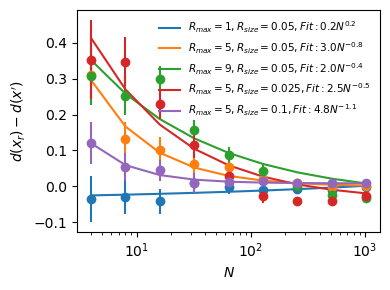

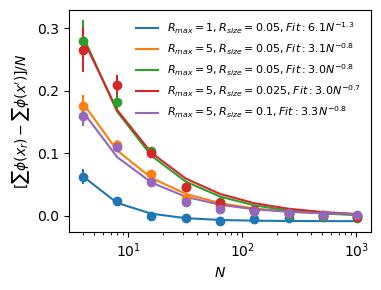

In [12]:
# density vs N
combinations = [(1, 0.05), (5, 0.05), (9, 0.05), (5, 0.025), (5, 0.1)]
comb_labels = {0: '1, 0.05', 1: '5, 0.05', 2: '9, 0.05', 3: '5, 0.025', 4: '5, 0.1'}
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

func_type = 'power'

f,ax = plt.subplots(1,1, figsize=(4,3))
f2,ax2 = plt.subplots(1,1, figsize=(4,3))

e = 1
threshold = thresholds[e]
for idx, (rmax, rsz) in enumerate(combinations):
    # rmax_idx = rmaxs.index(rmax)
    rmax_idx = rmaxs.index(rmax)
    rsz_idx = rszs.index(rsz)


    x = np.array(npcs)
    y = np.mean(deltas_dx[rmax_idx,rsz_idx,:,:,e],axis=1)
    yerr = np.std(deltas_dx[rmax_idx,rsz_idx,:,:,e],axis=1)/np.sqrt(seeds)

    line = ax.errorbar(x=npcs, y=y, yerr=yerr,fmt='o')
    ax.set_xscale('log')
    fit_color = line[0].get_color()
    ax.set_ylabel('$d(x_r) - d(x\')$')
    ax.set_xlabel('$N$')
    # ax.set_yscale('log')


    # Normalize y for fitting
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    # Fit model
    popt, func = fit_model(x, y_normalized, func_type)
    y_fit = func(x, *popt) * (np.max(y) - np.min(y)) + np.min(y)

    residuals = y - y_fit
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_value = np.round(1 - (ss_res / ss_tot),3)

    if func_type == 'exp':
        ax.plot(x, y_fit, label=f'$R_{{max}}={rmax}, R_{{size}}={rsz}, Fit:{popt[0]:.1f} e^{{{-popt[1]:.1f}N}}$',color=fit_color)
    else:
        ax.plot(x, y_fit, label=f'$R_{{max}}={rmax}, R_{{size}}={rsz}, Fit:{popt[0]:.1f} N^{{{-popt[1]:.1f}}}$', color=fit_color)
    ax.legend(frameon=False, fontsize=7.5)       
    # print(f'DX: $\sigma={sigma}, R_{{size}}={rsz}',r2_value)


    y = np.mean(deltas_mfa[rmax_idx,rsz_idx,:,:,e],axis=1)
    yerr = np.std(deltas_mfa[rmax_idx,rsz_idx,:,:,e],axis=1)/np.sqrt(seeds)

    line = ax2.errorbar(x=npcs, y=y, yerr=yerr,fmt='o')
    ax2.set_xscale('log')
    fit_color = line[0].get_color()
    ax2.set_ylabel('$[\sum \phi(x_r) - \sum \phi(x\')]/N$')
    ax2.set_xlabel('$N$')
    # ax.set_yscale('log')


    # Normalize y for fitting
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    # Fit model
    popt, func = fit_model(x, y_normalized, func_type)
    y_fit = func(x, *popt) * (np.max(y) - np.min(y)) + np.min(y)

    residuals = y - y_fit
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_value = np.round(1 - (ss_res / ss_tot),3)

    if func_type == 'exp':
        ax2.plot(x, y_fit, label=f'$R_{{max}}={rmax}, R_{{size}}={rsz}, Fit:{popt[0]:.1f} e^{{{-popt[1]:.1f}N}}$',color=fit_color)
    else:
        ax2.plot(x, y_fit, label=f'$R_{{max}}={rmax}, R_{{size}}={rsz}, Fit:{popt[0]:.1f} N^{{{-popt[1]:.1f}}}$', color=fit_color)
    ax2.legend(frameon=False, fontsize=8)        
    # print(f'DX: $\sigma={sigma}, R_{{size}}={rsz}',r2_value)



f.tight_layout()
# f.savefig('./svgs/dx_N_hetero.svg')

f2.tight_layout()
# f2.savefig('./svgs/mfa_N_hetero.svg')